In [1]:
#1
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
#from edge import *
import requests
import json
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(14,10), 'figure.dpi':120})

In [15]:
#2
full_data = pd.read_excel('7th month.xlsx', parse_dates=['datetime'], index_col='datetime')
full_data = full_data.apply(pd.to_numeric) 
full_data.sort_index(inplace=True)
#full_data.shape
full_data['exo'] = full_data['exo'].fillna(0)
demand_data_analysis = full_data.copy()
demand_data_analysis.tail()

,price,exo
datetime,,
2022.10.31 20:00:00,4000.0,0
2022.10.31 21:00:00,4000.0,0
2022.10.31 22:00:00,4000.0,0
2022.10.31 23:00:00,4000.0,0
2022.10.31 24:00:00,2000.0,0


In [3]:
full_data = pd.read_excel('masterfile 2cols sorted.xlsx', parse_dates=['datetime'], index_col='datetime')
full_data = full_data.apply(pd.to_numeric) 
full_data.sort_index(inplace=True)
full_data.shape

(29233, 1)

In [48]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 2022.10.01 01:00:00 to 2022.10.31 24:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   744 non-null    float64
 1   exo     744 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 17.4+ KB


In [5]:
demand_data_analysis = full_data.copy()
demand_data_analysis.shape

(744, 2)

In [50]:
mse_original = ((demand_data_analysis.nem_demand_forecast.to_numpy() - 
                 demand_data_analysis.nem_demand_actual.to_numpy()) ** 2).mean()
print('Mean square error of forecasted demand from source: {:.2f}'.format(mse_original))

AttributeError: 'DataFrame' object has no attribute 'nem_demand_forecast'

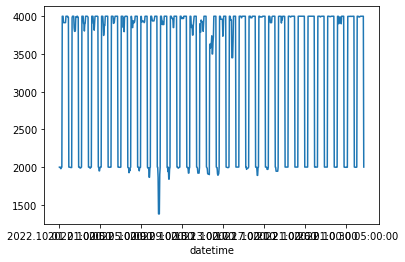

ADF Statistic: -8.097275681701229
p-value: 1.32863042946443e-12


In [6]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

#plt.figure(figsize=(600,100))
plt.rcParams["figure.figsize"] = (40,10)

# # Plot time series
demand_data_analysis['price'].plot()
plt.show()

# Run Dicky-Fuller test
result = adfuller(demand_data_analysis.price)

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

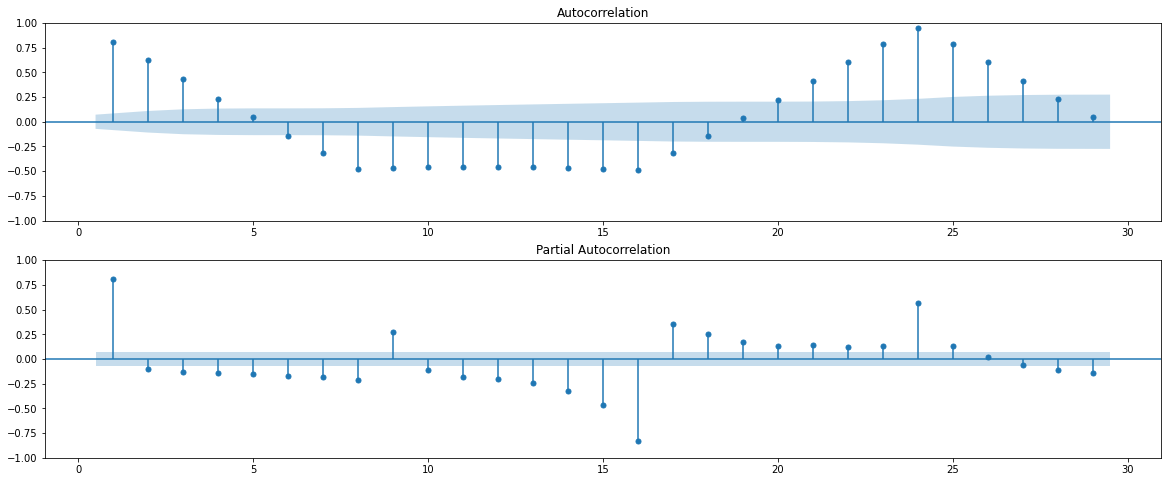

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import data
series = demand_data_analysis.price.interpolate().reset_index(drop=True)

# Create figure
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
 
# Plot the ACF of savings on ax1
plot_acf(demand_data_analysis.price, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(demand_data_analysis.price, zero=False, ax=ax2)

plt.show()

744


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 24 must be < 24.

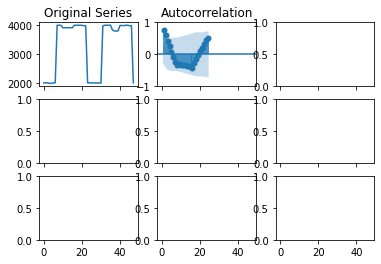

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF_LAGS = demand_data_analysis.shape[0] - 10
ACF_LAGS = 24
print(demand_data_analysis.shape[0])
# Import data
series = demand_data_analysis.price.reset_index(drop=True)[0:ACF_LAGS*2]

# Original Series
fig, axes = plt.subplots(3, 3, sharex=True)
axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
plot_acf(series, lags=ACF_LAGS, zero=False, ax=axes[0, 1]) 
plot_pacf(series, lags=ACF_LAGS, zero=False, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[1, 1])
plot_pacf(series.diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[2, 1])
plot_pacf(series.diff().diff().dropna(), lags=ACF_LAGS, zero=False, ax=axes[2, 2])

plt.show()

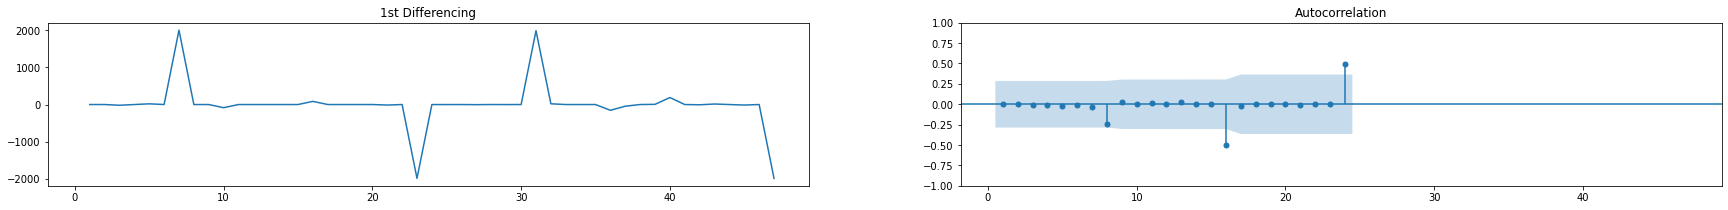

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(30,3))
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(series.diff().dropna(), ax=axes[1], lags=24, zero=False)

plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 24 must be < 23.

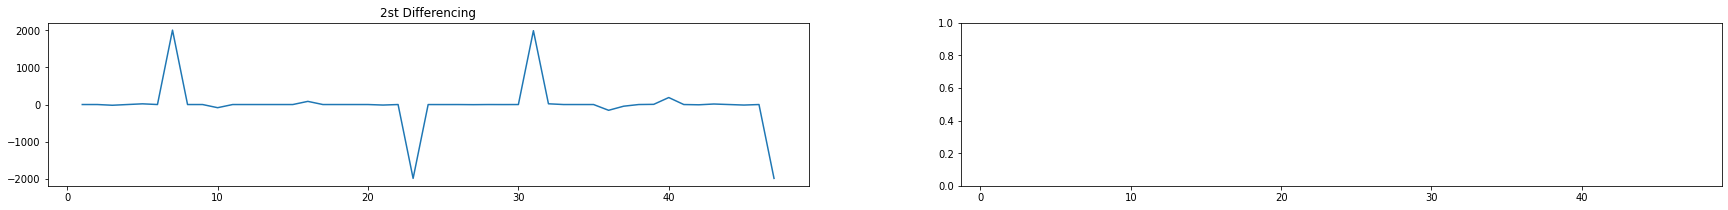

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(30,3))
axes[0].plot(series.diff()); axes[0].set_title('2st Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(series.diff().dropna(), ax=axes[1], lags=24, zero=False)

plt.show()

In [4]:
#3
from statsmodels.tsa.statespace.sarimax import SARIMAX

series = demand_data_analysis.price.reset_index(drop=True)

order_aic_bic=[]

for p in range(4):
    for q in range(4):
        for d in range(1,3):
            print('Processing {},{},{}...'.format(p,d,q))
            
            model = SARIMAX(series, order=(p,d,q),exogenous = demand_data_analysis['exo'])
            results = model.fit()

            order_aic_bic.append((p, d, q, results.aic, results.bic))


order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'AIC', 'BIC'])

Processing 0,1,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76843D+00    |proj g|=  2.32632D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.326D-06   7.768D+00
  F =   7.7684294512427989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 0,2,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly a

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.77855D+00    |proj g|=  1.77932D-03

At iterate   10    f=  7.76609D+00    |proj g|=  1.69491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     13      1     0     0   3.776D-06   7.763D+00
  F =   7.7631614673863067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 0,1,2...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76838D+00    |proj g|=  1.47369D-04

           * * *

Tit   = total number of iterati

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81552D+00    |proj g|=  3.74525D-02

At iterate    5    f=  7.77518D+00    |proj g|=  3.02273D-03

At iterate   10    f=  7.76854D+00    |proj g|=  7.54379D-04

At iterate   15    f=  7.76314D+00    |proj g|=  9.77378D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   9.774D-06   7.763D+00
  F =   7.7631381043128194     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processi

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82887D+00    |proj g|=  4.74421D-02


 This problem is unconstrained.



At iterate    5    f=  7.78887D+00    |proj g|=  1.89253D-02

At iterate   10    f=  7.77398D+00    |proj g|=  1.59469D-03

At iterate   15    f=  7.77249D+00    |proj g|=  3.46198D-03

At iterate   20    f=  7.76309D+00    |proj g|=  1.15594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   1.093D-05   7.763D+00
  F =   7.7630743866437690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Processing 1,1,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Processing 1,2,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95445D+00    |proj g|=  8.90226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.887D-06   7.954D+00
  F =   7.9544515794968831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 1,1,1...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly a


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  7.76318D+00    |proj g|=  1.87722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   5.164D-06   7.763D+00
  F =   7.7631365620403745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 1,1,2...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76844D+00    |proj g|=  5.12840D-03


 This problem is unconstrained.



At iterate    5    f=  7.76842D+00    |proj g|=  3.58486D-04

At iterate   10    f=  7.76840D+00    |proj g|=  3.34668D-03

At iterate   15    f=  7.76838D+00    |proj g|=  9.20588D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   9.206D-06   7.768D+00
  F =   7.7683782007582058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 1,2,2...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81824D+00    |proj g|=  

 This problem is unconstrained.



At iterate    5    f=  7.74420D+00    |proj g|=  7.36857D-03

At iterate   10    f=  7.73971D+00    |proj g|=  9.84520D-04

At iterate   15    f=  7.72983D+00    |proj g|=  4.68136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.044D-06   7.730D+00
  F =   7.7298160294137892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 1,1,3...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76843D+00    |proj g|=  

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4      6      1     0     0   1.680D-05   7.768D+00
  F =   7.7683713146245488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Processing 1,2,3...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19079D+00    |proj g|=  8.65149D-01


 This problem is unconstrained.



At iterate    5    f=  7.78431D+00    |proj g|=  3.81320D-02

At iterate   10    f=  7.75293D+00    |proj g|=  1.69393D-02

At iterate   15    f=  7.73826D+00    |proj g|=  2.15258D-02

At iterate   20    f=  7.73686D+00    |proj g|=  4.05894D-03

At iterate   25    f=  7.72789D+00    |proj g|=  6.72191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   1.249D-05   7.728D+00
  F =   7.7278938044308036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Processing 2,1,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   3.878D-06   7.898D+00
  F =   7.8982404292045238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 2,1,1...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76838D+00    |proj g|=  9.15576D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.77637D+00    |proj g|=  4.37046D-03

At iterate   15    f=  7.77470D+00    |proj g|=  4.94912D-04

At iterate   20    f=  7.77360D+00    |proj g|=  2.35513D-02

At iterate   25    f=  7.76307D+00    |proj g|=  2.31438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   7.231D-07   7.763D+00
  F =   7.7630745367346918     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 2,1,2...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77092D+00    |proj g|=  5.46368D-02

At iterate    5    f=  7.71737D+00    |proj g|=  2.57072D-02

At iterate   10    f=  7.69426D+00    |proj g|=  3.36985D-03

At iterate   15    f=  7.69300D+00    |proj g|=  2.66203D-03

At iterate   20    f=  7.69212D+00    |proj g|=  1.79057D-02

At iterate   25    f=  7.68668D+00    |proj g|=  2.89535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  7.73828D+00    |proj g|=  3.79732D-04

At iterate   15    f=  7.73800D+00    |proj g|=  3.19553D-04

At iterate   20    f=  7.73154D+00    |proj g|=  7.19470D-02

At iterate   25    f=  7.72750D+00    |proj g|=  5.05379D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   9.356D-07   7.727D+00
  F =   7.7274982007722173     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 2,1,3...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at

 This problem is unconstrained.



At iterate    5    f=  7.77962D+00    |proj g|=  9.78026D-04

At iterate   10    f=  7.77946D+00    |proj g|=  1.94812D-02

At iterate   15    f=  7.72693D+00    |proj g|=  1.43296D-01

At iterate   20    f=  7.71557D+00    |proj g|=  3.49063D-03

At iterate   25    f=  7.71500D+00    |proj g|=  2.87657D-02

At iterate   30    f=  7.71354D+00    |proj g|=  1.21194D-01

At iterate   35    f=  7.71255D+00    |proj g|=  1.15720D-02

At iterate   40    f=  7.71233D+00    |proj g|=  2.33468D-03

At iterate   45    f=  7.71231D+00    |proj g|=  3.37541D-03

At iterate   50    f=  7.71165D+00    |proj g|=  2.29541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.78360D+00    |proj g|=  7.19723D-02

At iterate   10    f=  7.76386D+00    |proj g|=  1.59035D-02

At iterate   15    f=  7.73638D+00    |proj g|=  1.81817D-02

At iterate   20    f=  7.72172D+00    |proj g|=  8.67641D-02

At iterate   25    f=  7.71897D+00    |proj g|=  1.07045D-02

At iterate   30    f=  7.71895D+00    |proj g|=  1.50647D-03

At iterate   35    f=  7.71884D+00    |proj g|=  1.65962D-02

At iterate   40    f=  7.71041D+00    |proj g|=  6.92574D-01

At iterate   45    f=  7.70910D+00    |proj g|=  2.79854D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     62   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   6.957D-06   7.768D+00
  F =   7.7683754142424837     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 3,2,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86849D+00    |proj g|=  9.78402D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   8.114D-06   7.868D+00
  F =   7.8684867131090162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 3,1,1...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76838D+00    |proj g|=  2.92870D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.82685D+00    |proj g|=  9.89687D-02

At iterate   10    f=  7.78932D+00    |proj g|=  5.77964D-02

At iterate   15    f=  7.77564D+00    |proj g|=  3.01334D-03

At iterate   20    f=  7.77465D+00    |proj g|=  1.83672D-03

At iterate   25    f=  7.77340D+00    |proj g|=  3.41273D-02

At iterate   30    f=  7.76307D+00    |proj g|=  1.06354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   5.100D-06   7.763D+00
  F =   7.7630719606654788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 3,1,2...
RUNNING THE L-BFGS-B CODE

    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.74597D+00    |proj g|=  4.25401D-02

At iterate   10    f=  7.73471D+00    |proj g|=  9.01843D-04

At iterate   15    f=  7.73444D+00    |proj g|=  3.21435D-04

At iterate   20    f=  7.72574D+00    |proj g|=  2.16403D-02

At iterate   25    f=  7.72334D+00    |proj g|=  1.12903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   5.792D-06   7.723D+00
  F =   7.7233411404659718     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Processing 3,1,3...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7 

 This problem is unconstrained.



At iterate    5    f=  7.77960D+00    |proj g|=  4.42074D-03
  ys=-1.662E-02  -gs= 2.345E-03 BFGS update SKIPPED

At iterate   10    f=  7.74954D+00    |proj g|=  2.81207D-01

At iterate   15    f=  7.72075D+00    |proj g|=  3.72287D-02

At iterate   20    f=  7.71497D+00    |proj g|=  6.68541D-01

At iterate   25    f=  7.71368D+00    |proj g|=  2.87963D-01

At iterate   30    f=  7.71337D+00    |proj g|=  3.19091D-01

At iterate   35    f=  7.71328D+00    |proj g|=  7.33607D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     69      1     1     0   6.939D-02   7.713D+00
  F =   7.7132805757378975     

 This problem is unconstrained.



At iterate    5    f=  7.80159D+00    |proj g|=  5.85135D-02

At iterate   10    f=  7.76417D+00    |proj g|=  3.14040D-02

At iterate   15    f=  7.74638D+00    |proj g|=  6.90590D-02

At iterate   20    f=  7.71739D+00    |proj g|=  2.49898D-02

At iterate   25    f=  7.71165D+00    |proj g|=  1.61653D-02

At iterate   30    f=  7.71152D+00    |proj g|=  3.14755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     37      1     0     0   3.148D-04   7.712D+00
  F =   7.7115192205767737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [12]:
order_df.sort_values('AIC').head()

,p,d,q,AIC,BIC
20,2,1,2,11447.778259,11470.831739
23,2,2,3,11482.816726,11510.472822
22,2,1,3,11486.927956,11514.592133
31,3,2,3,11488.740600,11521.006045
30,3,1,3,11491.361497,11523.636369


In [13]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC').head()

,p,d,q,AIC,BIC
20,2,1,2,11447.778259,11470.831739
23,2,2,3,11482.816726,11510.472822
22,2,1,3,11486.927956,11514.592133
31,3,2,3,11488.740600,11521.006045
30,3,1,3,11491.361497,11523.636369


In [5]:
# Fit model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(series, order=(2,1,3))#213
results = model.fit()

# Assign residuals to variable
residuals = results.resid

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77970D+00    |proj g|=  1.22765D-02

At iterate    5    f=  7.77962D+00    |proj g|=  9.78026D-04

At iterate   10    f=  7.77946D+00    |proj g|=  1.94812D-02

At iterate   15    f=  7.72693D+00    |proj g|=  1.43296D-01

At iterate   20    f=  7.71557D+00    |proj g|=  3.49063D-03

At iterate   25    f=  7.71500D+00    |proj g|=  2.87657D-02

At iterate   30    f=  7.71354D+00    |proj g|=  1.21194D-01

At iterate   35    f=  7.71255D+00    |proj g|=  1.15720D-02

At iterate   40    f=  7.71233D+00    |proj g|=  2.33468D-03

At iterate   45    f=  7.71231D+00    |proj g|=  3.37541D-03

At iterate   50    f=  7.71165D+00    |proj g|=  2.29541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [15]:
mae = np.mean(np.abs(residuals))
mae

293.57232178782186

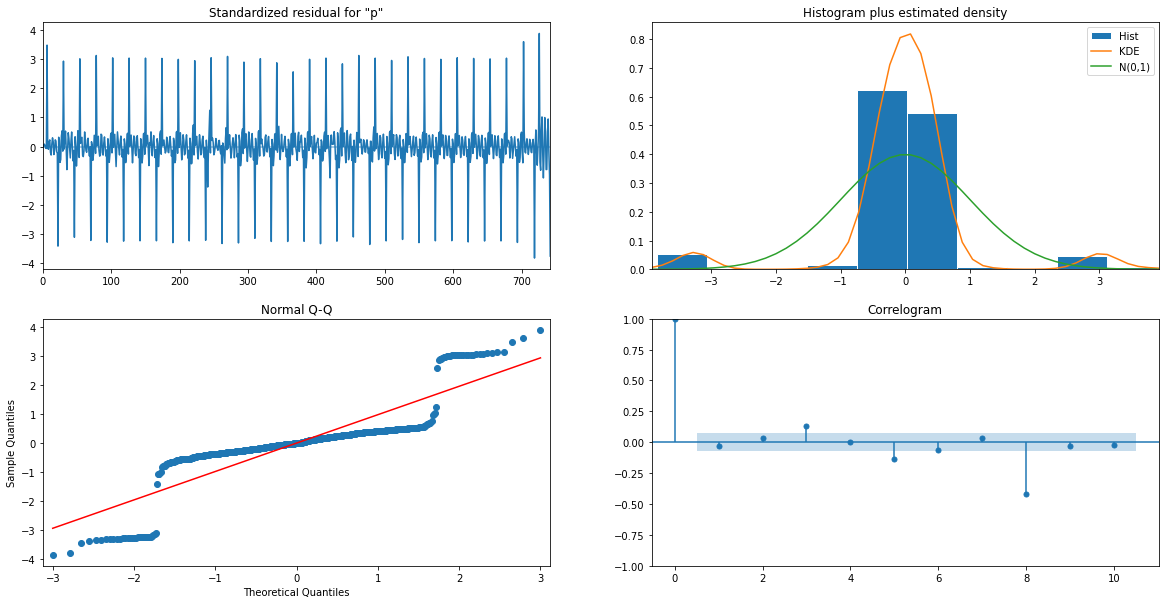

In [16]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(20,10))
plt.show()

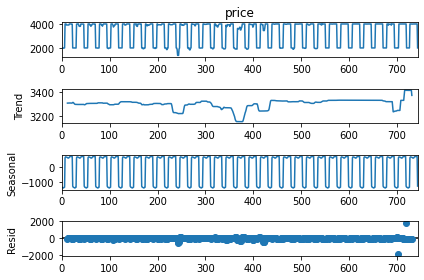

In [4]:
import pylab
pylab.rcParams['figure.figsize'] = (20,10)

# Import data
series = demand_data_analysis.price.interpolate().reset_index(drop=True)

from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 24

decomp_results = seasonal_decompose(series, model='additive',period=decompfreq)

decomp_results.plot()
plt.show()

In [18]:
#4
from statsmodels.tsa.statespace.sarimax import SARIMAX

DIFF = 24 #decompfreq
ns_order = (2,1,3) #213

# Import data
series = demand_data_analysis.price.interpolate().reset_index(drop=True)
#series.head()
#Create empty list to store search results
order_aic_bic_seasonal=[]

for P in range(4):
    for Q in range(4):
        for D in range(1):
            print('Processing {},{},{}...'.format(P,D,Q))

            # create and fit SARIMAX(p,d,q,P,D,Q,DIFF) model
            model = SARIMAX(series, order=ns_order, seasonal_order=(P,D,Q,DIFF),exogenous = demand_data_analysis['exo'])
            try:
                results = model.fit()

                # Append order and results tuple
                order_aic_bic_seasonal.append((P, D, Q, results.aic, results.bic))
            except:
                pass
        
# Construct DataFrame from order_aic_bic
order_seasonal_df = pd.DataFrame(order_aic_bic_seasonal, columns=['P', 'D', 'Q', 'AIC', 'BIC'])

Processing 0,0,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77970D+00    |proj g|=  1.22765D-02


 This problem is unconstrained.



At iterate    5    f=  7.77962D+00    |proj g|=  9.78026D-04

At iterate   10    f=  7.77946D+00    |proj g|=  1.94812D-02

At iterate   15    f=  7.72693D+00    |proj g|=  1.43296D-01

At iterate   20    f=  7.71557D+00    |proj g|=  3.49063D-03

At iterate   25    f=  7.71500D+00    |proj g|=  2.87657D-02

At iterate   30    f=  7.71354D+00    |proj g|=  1.21194D-01

At iterate   35    f=  7.71255D+00    |proj g|=  1.15720D-02

At iterate   40    f=  7.71233D+00    |proj g|=  2.33468D-03

At iterate   45    f=  7.71231D+00    |proj g|=  3.37541D-03


/home/denis-root/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.71165D+00    |proj g|=  2.29541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     0     0   2.295D-02   7.712D+00
  F =   7.7116451319888553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Processing 0,0,1...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81697D+00    |proj g|=  1.21295D+00

At iterate    5    f=  7.44318D+00    |proj g|=  1.82823D-02

At iterate   10    f=  7.44246D+00    |proj g|=  2.61300D-03

At iterate   15    f=  7.43812D+00    |proj g|=  2.80617D-02

At iterate   20    f=  7.35548D+00    |proj g|=  3.80175D-02

At iterate   25    f=  7.35387D+00    |proj g|=  2.52103D-03
  ys=-3.978E-03  -gs= 2.828E-03 BFGS update SKIPPED

At iterate   30    f=  7.33797D+00    |proj g|=  2.84324D-02

At iterate   35    f=  7.33256D+00    |proj g|=  8.65819D-04

At iterate   40    f=  7.33256D+00    |proj g|=  6.02461D-04

At iterate   45    f=  7.33251D+00    |proj g|=  3.34440D-04


/home/denis-root/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.31514D+00    |proj g|=  5.15323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     80      1     1     0   5.153D-02   7.315D+00
  F =   7.3151447670490368     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Processing 0,0,2...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77970D+00    |proj g|=  1.10007D+00

At iterate    5    f=  7.35637D+00    |proj g|=  5.29876D-03

At iterate   10    f=  7.35622D+00    |proj g|=  1.71708D-03

At iterate   15    f=  7.35178D+00    |proj g|=  3.40749D-02

At iterate   20    f=  7.32675D+00    |proj g|=  4.49205D-02

At iterate   25    f=  7.13254D+00    |proj g|=  3.12765D-02

At iterate   30    f=  7.12928D+00    |proj g|=  1.61800D-04

At iterate   35    f=  7.12927D+00    |proj g|=  1.01382D-03
  ys=-1.395E-02  -gs= 1.187E-03 BFGS update SKIPPED

At iterate   40    f=  7.11261D+00    |proj g|=  2.71180D-02

At iterate   45    f=  7.11107D+00    |proj g|=  2.86922D-04


/home/denis-root/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.11105D+00    |proj g|=  2.68934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     1     0   2.689D-03   7.111D+00
  F =   7.1110539961291970     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Processing 0,0,3...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77970D+00    |proj g|=  1.10007D+00

At iterate    5    f=  7.32127D+00    |proj g|=  4.03279D-03

At iterate   10    f=  7.32103D+00    |proj g|=  2.17501D-03

At iterate   15    f=  7.31213D+00    |proj g|=  3.39961D-02

At iterate   20    f=  7.20810D+00    |proj g|=  8.65641D-02

At iterate   25    f=  7.02931D+00    |proj g|=  1.73765D-02

At iterate   30    f=  6.99570D+00    |proj g|=  6.05291D-03

At iterate   35    f=  6.99561D+00    |proj g|=  6.17331D-04

At iterate   40    f=  6.98286D+00    |proj g|=  5.44602D-02

At iterate   45    f=  6.97981D+00    |proj g|=  4.35629D-03


/home/denis-root/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.97973D+00    |proj g|=  1.28414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     84      1     0     0   1.284D-04   6.980D+00
  F =   6.9797308173919346     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Processing 1,0,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.28016D+00    |proj g|=  5.65811D-02


 This problem is unconstrained.



At iterate    5    f=  7.26017D+00    |proj g|=  4.21462D-03

At iterate   10    f=  7.25273D+00    |proj g|=  4.02486D-03

At iterate   15    f=  6.98826D+00    |proj g|=  3.00290D-01

At iterate   20    f=  6.83474D+00    |proj g|=  5.63151D-03

At iterate   25    f=  6.78754D+00    |proj g|=  1.53957D-02

At iterate   30    f=  6.78564D+00    |proj g|=  6.69574D-03

At iterate   35    f=  6.78350D+00    |proj g|=  3.32319D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/denis-root/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38    128      2     0     0   1.371D+01   6.636D+00
  F =   6.6361920608609024     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Processing 1,0,1...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65726D+00    |proj g|=  2.28205D-01


 This problem is unconstrained.



At iterate    5    f=  7.23986D+00    |proj g|=  2.88790D-03

At iterate   10    f=  7.22863D+00    |proj g|=  2.18916D-02

At iterate   15    f=  7.16750D+00    |proj g|=  3.59916D-02

At iterate   20    f=  6.67262D+00    |proj g|=  8.24076D-02

At iterate   25    f=  6.39160D+00    |proj g|=  4.72463D-02

At iterate   30    f=  6.38438D+00    |proj g|=  1.19461D-02

At iterate   35    f=  6.38135D+00    |proj g|=  1.19663D-02

At iterate   40    f=  6.37191D+00    |proj g|=  4.56342D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  6.36484D+00    |proj g|=  1.08025D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49    127      2     0     0   1.336D-02   6.365D+00
  F =   6.3648112725038892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Processing 1,0,2...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.28812D+00    |proj g|=  1.12271D-01


 This problem is unconstrained.



At iterate    5    f=  7.23924D+00    |proj g|=  1.73253D-03

At iterate   10    f=  7.23674D+00    |proj g|=  1.73293D-02
  ys=-3.209E-01  -gs= 3.054E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  7.19803D+00    |proj g|=  2.18564D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/denis-root/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     20    101      3     1     0   2.444D-02   7.192D+00
  F =   7.1923843374676242     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Processing 1,0,3...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34817D+00    |proj g|=  2.01198D-01


 This problem is unconstrained.



At iterate    5    f=  7.23959D+00    |proj g|=  7.50326D-03

At iterate   10    f=  7.23859D+00    |proj g|=  2.65609D-03

At iterate   15    f=  7.22385D+00    |proj g|=  1.69769D-02

At iterate   20    f=  7.19723D+00    |proj g|=  2.82557D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-5.288E-05  -gs= 6.003E-05 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23    105      2     1     0   2.978D-01   7.195D+00
  F =   7.1950636401713508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Processing 2,0,0...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27468D+00    |proj g|=  3.87291D-02


 This problem is unconstrained.



At iterate    5    f=  7.24378D+00    |proj g|=  1.09770D-02

At iterate   10    f=  7.23720D+00    |proj g|=  4.49012D-03

At iterate   15    f=  6.84894D+00    |proj g|=  5.85327D+00
  ys=-2.194E-03  -gs= 1.201E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  6.84820D+00    |proj g|=  3.64803D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.676E+05  -gs= 2.814E+02 BFGS update SKIPPED
Processing 2,0,1...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26562D+00    |proj g|=  3.82318D-02

At iterate    5    f=  7.24194D+00    |proj g|=  3.28583D-03

At iterate   10    f=  7.23550D+00    |proj g|=  1.99510D-02

At iterate   15    f=  7.22815D+00    |proj g|=  3.60090D-03

At iterate   20    f=  2.86451D-01    |proj g|=  5.17363D+04
Processing 2,0,2...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25863D+00    |proj g|=  3.76186D-02


 This problem is unconstrained.



At iterate    5    f=  7.23920D+00    |proj g|=  1.73636D-03

At iterate   10    f=  7.23663D+00    |proj g|=  1.73386D-02

At iterate   15    f=  7.21103D+00    |proj g|=  1.77776D-02

At iterate   20    f=  7.00984D+00    |proj g|=  1.93642D-01
Processing 2,0,3...


In [8]:
order_seasonal_df.sort_values('AIC').head()

,P,D,Q,AIC,BIC
5,1,0,1,9486.839173,9523.724742
4,1,0,0,9888.653787,9920.928659
3,0,0,3,10403.839456,10445.335721
8,2,0,2,10450.613242,10496.720202
9,2,0,3,10496.298700,10547.016357


In [ ]:
order_seasonal_df.sort_values('BIC').head()

,P,D,Q,AIC,BIC
3,0,0,3,10450.315218,10487.200787
2,0,0,2,10545.868874,10578.143747
4,1,0,1,10806.704266,10838.979138
5,2,0,1,10804.906987,10841.792556
1,0,0,1,10850.745232,10878.409408


In [5]:
#5
# Create a SARIMAX model
DIFF = 24 #decompfreq
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(series, order=(2,1,2), seasonal_order=(3,1,0,DIFF))#310

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17829D+00    |proj g|=  3.80203D-02

At iterate    5    f=  6.16531D+00    |proj g|=  9.39717D-03

At iterate   10    f=  6.15594D+00    |proj g|=  7.23968D-03

At iterate   15    f=  6.07835D+00    |proj g|=  1.16642D-02

At iterate   20    f=  6.07802D+00    |proj g|=  1.00687D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     25      1     0     0   6.691D-06   6.078D+00
  F =   6.0780167296112300     

CONVERG

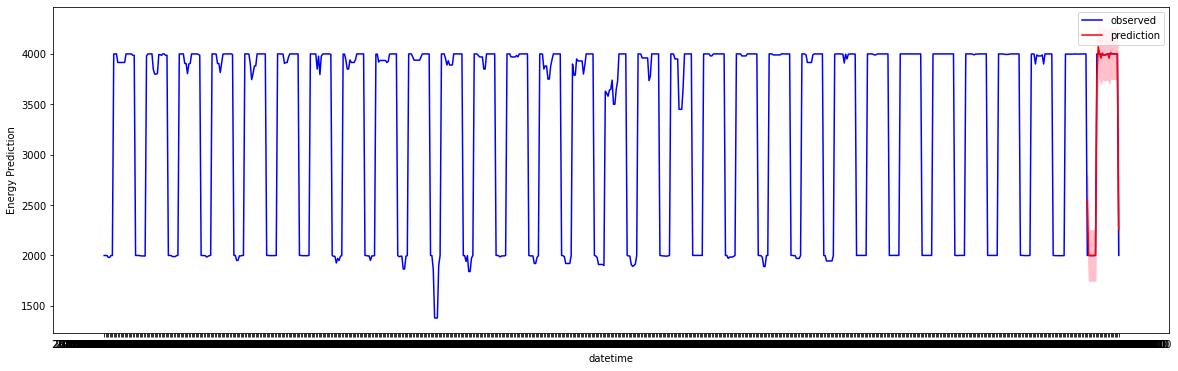

In [10]:

# Import data
series_df = demand_data_analysis.price

NUM_OF_STEPS = 24
# Generate predictions
one_step_forecast = results.get_prediction(start=-NUM_OF_STEPS, dynamic=False)
# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower price']
upper_limits = confidence_intervals.loc[:,'upper price']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(20,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='prediction')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('datetime')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

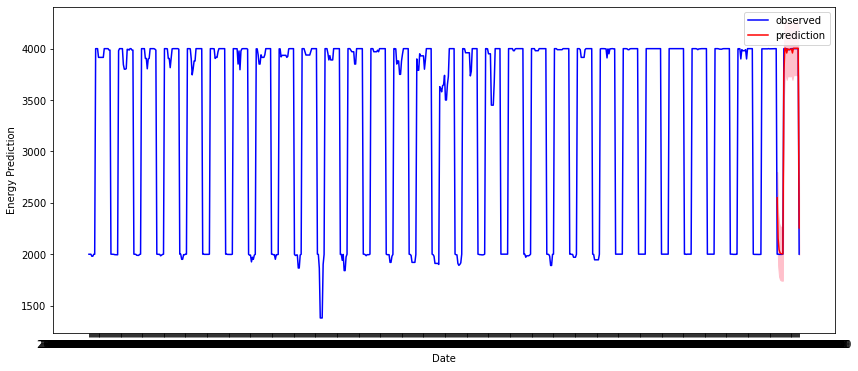

In [11]:
# Import data
series_df = demand_data_analysis.price

NUM_OF_STEPS = 24
# Generate predictions
dynamic_forecast = results.get_prediction(start=-NUM_OF_STEPS, dynamic=True)
# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean
mean_forecast_x = demand_data_analysis.index[-NUM_OF_STEPS:]

forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=mean_forecast_x, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = dynamic_forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower price']
upper_limits = confidence_intervals.loc[:,'upper price']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=mean_forecast_x, 
                           columns = ['lower_limits','upper_limits'])

plt.figure(figsize=(14,6))

# plot the amazon data
plt.plot(series_df, color='b', label='observed')

# plot your mean predictions
plt.plot(forecast_df, color='r', label='prediction')

# shade the area between your confidence limits
plt.fill_between(conf_int_df.index, conf_int_df.lower_limits, 
                 conf_int_df.upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Energy Prediction')
plt.legend()
plt.show()

In [6]:
#6
PERIOD = '1H'
#FORECAST_DURATION = '1 day'

# Import data
series_df = demand_data_analysis.price

# Creating the forecast index
from datetime import datetime, timedelta

# Set start and end dates
start = "2022.10.01" #series_df.index[0]
end = "2022.10.31"    #series_df.index[-1]
start_forecast = '2022.11.01'
end_forecast = '2022.11.02'

# Orginal and forecast index
org_datetime = pd.date_range(start, end, freq=PERIOD)
forecast_datetime = pd.date_range(start_forecast, end_forecast, freq=PERIOD)

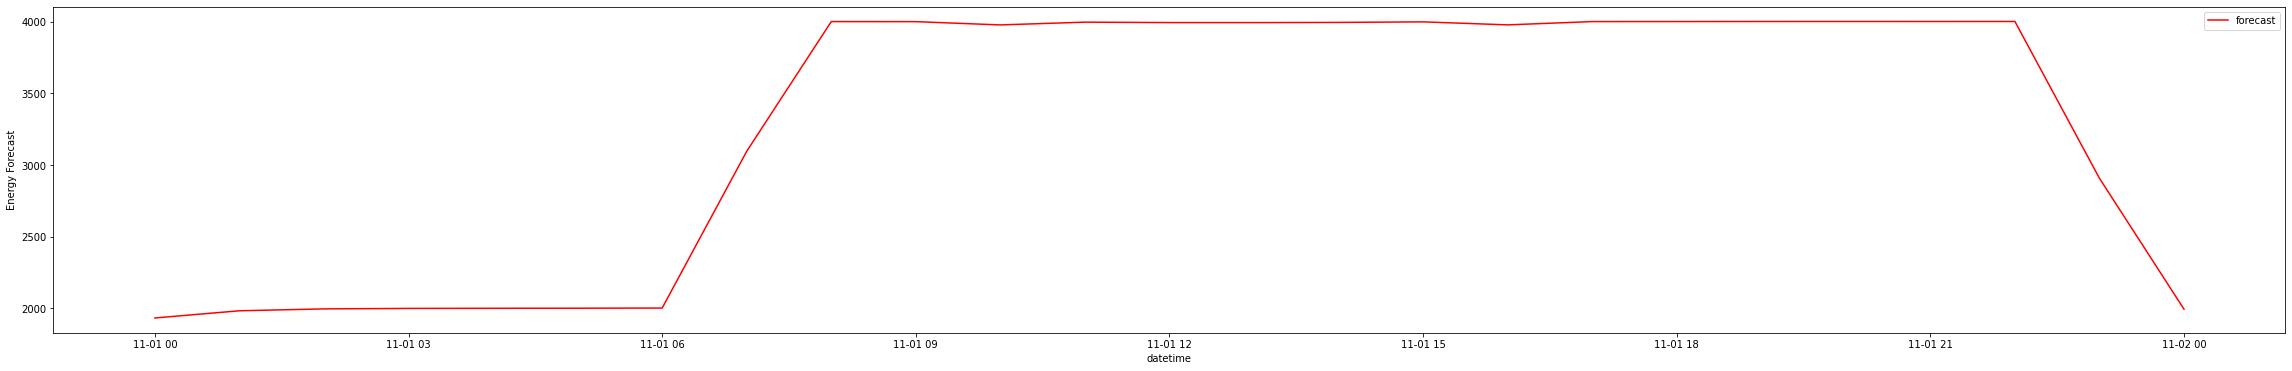

In [7]:
#7
# Preparing the time series plots
#NUM_OF_STEPS_AHEAD = 24
NUM_OF_STEPS_AHEAD = len(forecast_datetime)
# Generate predictions
forecast = results.get_forecast(steps=NUM_OF_STEPS_AHEAD)
series_df = demand_data_analysis.price
# Extract prediction mean
mean_forecast = forecast.predicted_mean
#mead_forcast_x = forecast_datetime
forecast_df = pd.DataFrame(mean_forecast.to_list(), 
                           index=forecast_datetime, columns = ['forecast'])

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()
# confidence_intervals
# # Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower price']
upper_limits = confidence_intervals.loc[:,'upper price']
conf_int_df = pd.DataFrame(list(zip(lower_limits, upper_limits)), index=forecast_datetime, 
                           columns = ['lower_limits','upper_limits'])

## Connecting the series
series_df = pd.concat([series_df, forecast_df.forecast])#[:len(series_df)+1]

#print(series_df) #to prood values
#forecast_df.head()
plt.figure(figsize=(40,6))

# # plot your mean predictions
plt.plot(forecast_df, color='r', label='forecast')

# # # plot the amazon data
#plt.plot(series_df , color='b', label='observed')


# # shade the area between your confidence limits
#plt.fill_between(conf_int_df.index, conf_int_df.lower_limits,  conf_int_df.upper_limits, color='pink')

plt.savefig('web-interface/static/trendline.png')

# set labels, legends and show plot
plt.xlabel('datetime')
plt.ylabel('Energy Forecast')
plt.legend()
plt.show()

In [32]:
full_data = pd.read_excel('7th month.xlsx', parse_dates=['datetime'], index_col='datetime')
full_data = full_data.apply(pd.to_numeric) 
full_data.sort_index(inplace=True)
#full_data.shape
#full_data['exo'] = full_data['exo'].fillna(0)

demand_data_analysis = full_data.copy()
#demand_data_analysis = demand_data_analysis.apply (pd.to_numeric, errors='coerce')
#demand_data_analysis.dropna()
#demand_data_analysis['datetime'] = demand_data_analysis['datetime'].fillna(0)
demand_data_analysis['price'] = demand_data_analysis['price'].fillna(0)
#demand_data_analysis.tail()
forecast_df25 = forecast_df.tail(24).copy()
forecast_df25.dropna()
demand_data_analysis = demand_data_analysis.tail(24).copy()
demand_data_analysis.dropna()
# demand_data_analysis.shape
#mse_original = ((demand_data_analysis.price.to_numpy() - 
 #                   forecast_df25.forecast.to_numpy()) ** 2).mean()
#print('Mean square error of forecasted demand from source: {:.2f}'.format(mse_original/24))
from sklearn.metrics import mean_squared_error
#print(demand_data_analysis.price,forecast_df25.forecast)
mean_squared_error( demand_data_analysis.price.to_numpy(),forecast_df25.forecast.to_numpy())
#forecast_df.tail(24)
#demand_data_analysis.head(25)

99864.70381912346

Перелік умовних позначень та скорочень
Вступ

1. Аналіз задачі прогнозування показників продажу електроенергії на сегменті ринку "На добу наперед"
    1.1 Нова модель ринку електричної енергії України 
    1.2 Актуальність прогнозування показників продажу електроенергії  
    1.3 Аналіз способів прогнозування часових рядів
    1.4 Порівняння авторегресійних моделей
        1.4.1 Модель AR
        1.4.2 Модель ARIMA
        1.4.3 Модель SARIMA
        1.4.4 Модель SARIMAX
    1.5 Вибір авторегресійної моделі 
    1.6 Постановка задачі дослідження
  Висновки до розділу 1
2. Прогнозування на основі авторегресійної моделі SARIMAX
    2.1 Огляд математичної складової обраної моделі 
    2.2 Аналіз ключових статистичних показників
    2.2 Визначення вхідних параметрів для моделі
    2.3 Формування прогнозу та визначення похибки прогнозування  
  Висновки до розділу 2
3. Реалізація системи
    3.1 Вибір засобів реалізації системи
    3.2 Архітектура системи
    3.3 Інтерфейс системи
  Висновки до розділу 3
4. Планування стартап-проєкту
    4.1 Опис ідеї проекту
    4.2 Аналіз ринкових можливостей запуску стартап-проекту
    4.3 Розробка ринкової стратегії проекту
    4.4 Розробка маркетингової програми стартап-проекту
  Висновки до розділу 4

Висновки за роботою та перспективи для подальших досліджень
Перелік посилань

завантажили, проаназіували, змінили вхідні дані( лаги) оцінили ступінь кореляції, робимо висновок- для моделі такі то дані - 
вхідні